In [ ]:
#I have Used python 3.11 version because of the conflict in the frameworks
# Importing the essential libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Enhanced visualization
import tensorflow as tf  # Deep learning framework
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score  # Model evaluation
from sklearn.utils.class_weight import compute_class_weight  # Class imbalance handling
from tensorflow.keras.models import Sequential  # Sequential model type
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, Flatten  # CNN layers
from tensorflow.keras.optimizers import Adam  # Optimization algorithm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Training callbacks
from tensorflow.keras.utils import to_categorical  # Label encoding

In [ ]:
#Importing the dataset and loading the dataset for further data preprocessing
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

In [ ]:
# Combining for analysis
full_df = pd.concat([train_df, test_df])
labels = full_df[187].astype(int)
features = full_df.drop(187, axis=1)

In [4]:
print("Dataset shape:", full_df.shape)
print("\nClass distribution:")
print(labels.value_counts())

Dataset shape: (109446, 188)

Class distribution:
187
0    90589
4     8039
2     7236
1     2779
3      803
Name: count, dtype: int64


C:\Users\banso\AppData\Local\Temp\ipykernel_19164\604168246.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


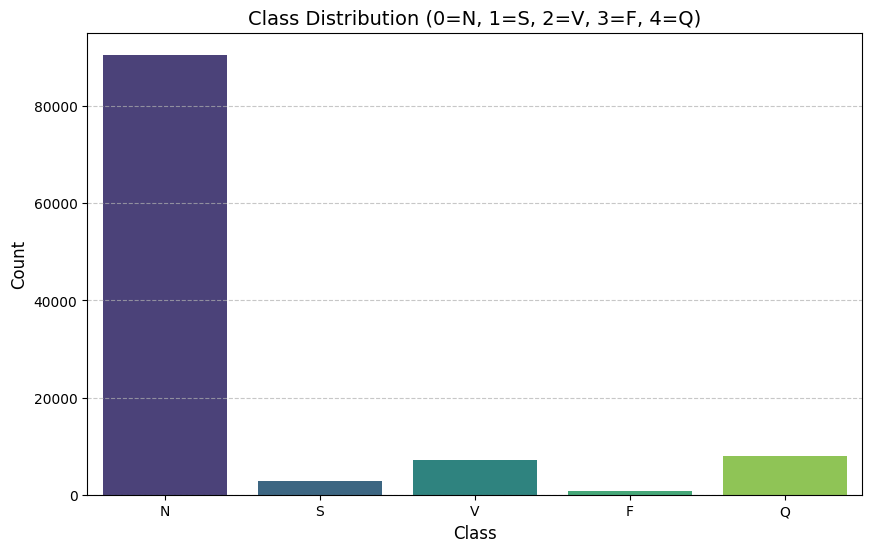

In [ ]:
# Visualizing the actual class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=labels, palette="viridis")
plt.title("Class Distribution (0=N, 1=S, 2=V, 3=F, 4=Q)", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0,1,2,3,4], labels=['N', 'S', 'V', 'F', 'Q'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

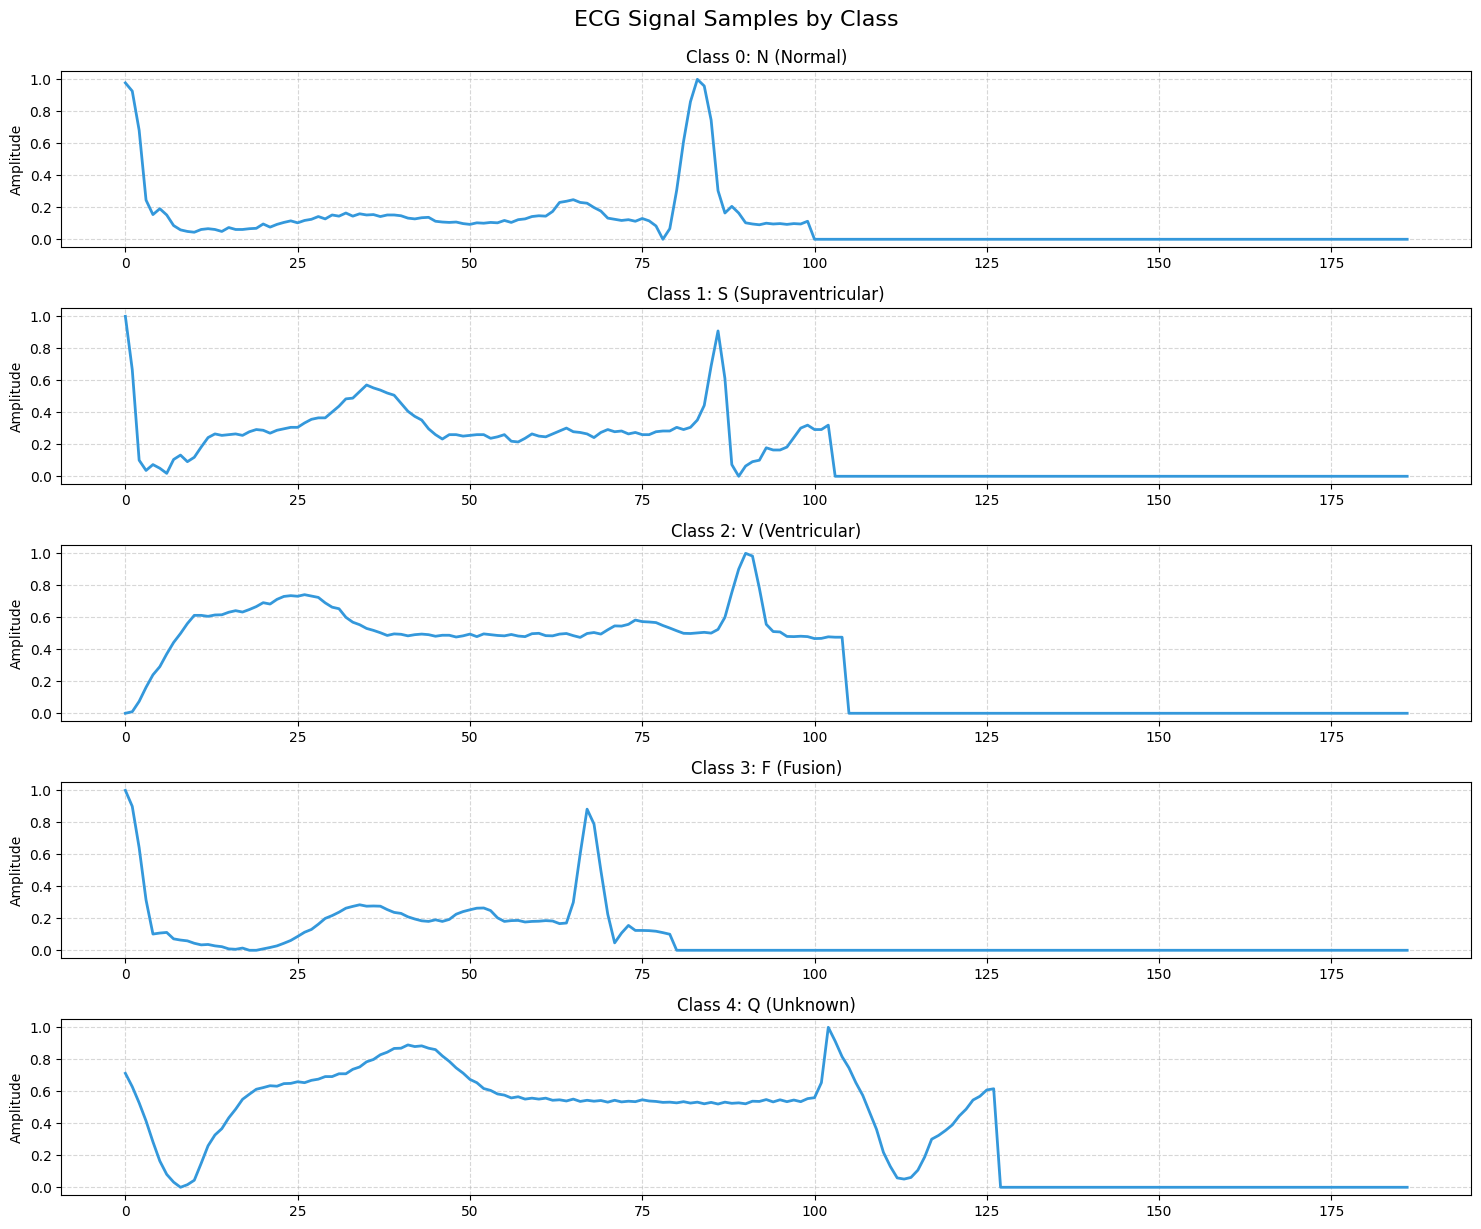

In [ ]:
# Plot ECG signals
class_names = ['N (Normal)', 'S (Supraventricular)', 'V (Ventricular)', 
            'F (Fusion)', 'Q (Unknown)']
plt.figure(figsize=(15, 12))
for i in range(5):
    plt.subplot(5, 1, i+1)
    class_samples = features[labels == i].iloc[0]
    plt.plot(class_samples, color='#3498db', linewidth=2)
    plt.title(f"Class {i}: {class_names[i]}", fontsize=12)
    plt.ylabel("Amplitude", fontsize=10)
    plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.suptitle("ECG Signal Samples by Class", fontsize=16, y=1.02)
plt.show()


Data Preprocessing

In [ ]:

# Extracting features and labels
X_train = train_df.iloc[:, :-1].values.astype(np.float32)
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values.astype(np.float32)
y_test = test_df.iloc[:, -1].values

In [ ]:
# Normalization 
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [9]:
# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Converting to categorical values
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [ ]:
# Spliting validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.1, random_state=42, stratify=y_train
)

In [12]:
print("\nClass Distribution:")
print(f"- Class 0: {sum(y_train == 0)} samples")
print(f"- Class 1: {sum(y_train == 1)} samples")
print(f"- Class 2: {sum(y_train == 2)} samples")
print(f"- Class 3: {sum(y_train == 3)} samples")
print(f"- Class 4: {sum(y_train == 4)} samples")


Class Distribution:
- Class 0: 72471 samples
- Class 1: 2223 samples
- Class 2: 5788 samples
- Class 3: 641 samples
- Class 4: 6431 samples


In [ ]:
# Calculate class weights to handle imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [14]:
print("\nClass Weights:")
for k, v in class_weight_dict.items():
    print(f"- Class {k}: {v:.2f}")



Class Weights:
- Class 0: 0.24
- Class 1: 7.88
- Class 2: 3.03
- Class 3: 27.32
- Class 4: 2.72


cnn model


In [ ]:
def build_balanced_cnn():
    model = Sequential([
        # First convolutional block
        Conv1D(32, 5, activation='relu', input_shape=(187, 1), padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        # Second convolutional block

        Conv1D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
    # Third convolutional block
        
        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),
            # Compiling the model with Adam optimizer and categorical crossentropy loss

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(5, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

model = build_balanced_cnn()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           192       
                                                                 
 batch_normalization (Batch  (None, 187, 32)           128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 93, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 93, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 64)            6208      
                                                                 
 batch_normalization_1 (Bat  (None, 93, 64)           

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]
# Training the model with class weights

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Critical for handling imbalance
    verbose=1
)

Epoch 1/50


616/616 [==============================] - 45s 67ms/step - loss: 0.7524 - accuracy: 0.6529 - val_loss: 1.7937 - val_accuracy: 0.3360 - lr: 0.0010
Epoch 2/50
616/616 [==============================] - 40s 65ms/step - loss: 0.4755 - accuracy: 0.7496 - val_loss: 0.6722 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 3/50
616/616 [==============================] - 40s 65ms/step - loss: 0.4053 - accuracy: 0.8116 - val_loss: 0.5697 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 4/50
616/616 [==============================] - 40s 64ms/step - loss: 0.3821 - accuracy: 0.8302 - val_loss: 0.6519 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 5/50
616/616 [==============================] - 38s 61ms/step - loss: 0.3314 - accuracy: 0.8422 - val_loss: 0.4213 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 6/50
616/616 [==============================] - 36s 58ms/step - loss: 0.3324 - accuracy: 0.8504 - val_loss: 0.3833 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 7/50
616/616 [==============================] - 37

Model Evaluation

In [ ]:
## Evaluation of the model on test set
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9470
Test Loss: 0.1579


In [18]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_oh, axis=1)

685/685 [==============================] - 4s 5ms/step


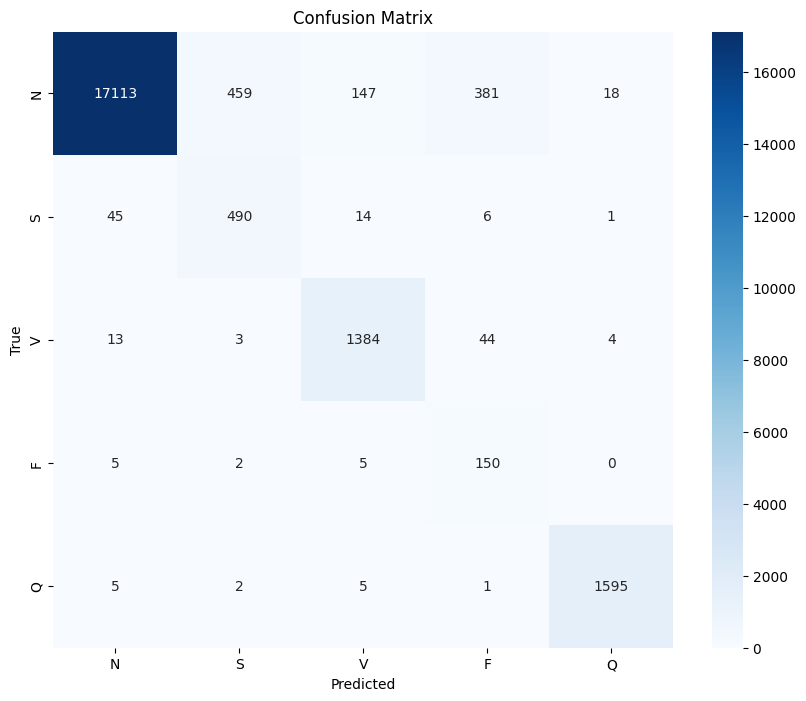

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['N', 'S', 'V', 'F', 'Q'], 
            yticklabels=['N', 'S', 'V', 'F', 'Q'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Classification Report
print(classification_report(y_test_classes, y_pred_classes, 
                        target_names=['N', 'S', 'V', 'F', 'Q']))

              precision    recall  f1-score   support

           N       1.00      0.94      0.97     18118
           S       0.51      0.88      0.65       556
           V       0.89      0.96      0.92      1448
           F       0.26      0.93      0.40       162
           Q       0.99      0.99      0.99      1608

    accuracy                           0.95     21892
   macro avg       0.73      0.94      0.79     21892
weighted avg       0.97      0.95      0.96     21892



In [21]:
# ROC-AUC
print("Macro ROC-AUC:", roc_auc_score(y_test_oh, y_pred, multi_class='ovr', average='macro'))

Macro ROC-AUC: 0.9916528995320089


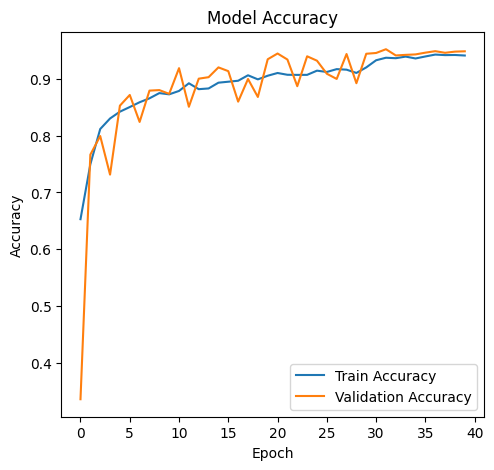

In [ ]:
#Visualize Training
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

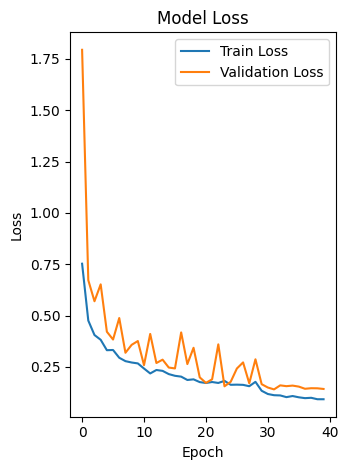

In [23]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Save Model
model.save('ecg_balanced_cnn.h5')
print("Model saved as 'ecg_balanced_cnn.h5'")

Model saved as 'ecg_balanced_cnn.h5'


d:\assignment\task 1\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
